In [1]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

saveFigs = False

In [2]:
import sys 
import os
sys.path.append('../')

from BackDiffuse_LT import BackDiffuse
from GetCoreData_fct import GetCoreData



from Interpolation_Class import Interpolation

# Stability Test 3
### Testing stability by changing interpolation of data before back diffusion.

Load data of interest for specific core.

In [3]:
CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


In [165]:
site = 'Crete'

core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']


DataAll = GetCoreData(site)

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']


No ECM file found, setting empty df instead


Set a first guess on interpolation as somewhere in btw. max sampling size and min sampling size.

In [203]:
maxDiff = max(np.diff(depth_LT))
minDiff = min(np.diff(depth_LT))
Delta0 = 0.13#(maxDiff + minDiff)/2 
#Delta0
N_yrs = 32


Make interpolation (from interpolation class).

In [204]:
interval = np.array([min(depth_LT), max(depth_LT)])

interpTypeAll = 'CubicSpline'

inst = Interpolation(depth_LT, pd.Series(d18O_LT), interval, interpTypeAll, DeltaInput=True, samplingSize=Delta0)
depth_LT_int, d18O_LT_int, Delta = inst()

ave_dist = (depth_LT_int[-1] - depth_LT_int[0])/N_yrs
ave_Npoints = ave_dist/Delta
min_peakDist = int(ave_Npoints/3)


Plot interpolated and inital data together. Find peak positions and plot as well.

22


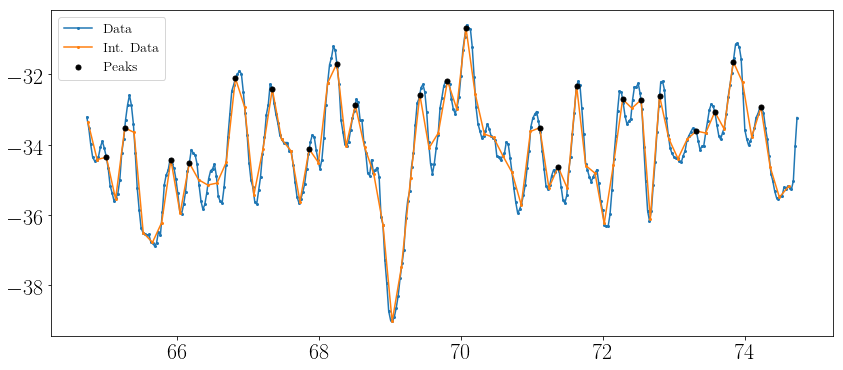

In [205]:
fig, ax = plt.subplots(figsize=(14,6))

from scipy import signal
if min_peakDist == 0:
    peaksTest = signal.find_peaks(d18O_LT_int)[0]
    
else:
    peaksTest = signal.find_peaks(d18O_LT_int, distance=min_peakDist)[0]

plt.plot(depth_LT,d18O_LT,'-',marker='.',ms=4, label='Data')
plt.plot(depth_LT_int,d18O_LT_int,'-',marker='.',ms=4, label='Int. Data')
plt.plot(depth_LT_int[peaksTest],d18O_LT_int[peaksTest],'.', color='k', ms=10,label='Peaks')
plt.legend(fontsize=14)
print(len(peaksTest))

Create new dataframe with new interpolated data.

In [206]:
dataAll = pd.DataFrame({'depth':depth_LT_int,'d18O':d18O_LT_int}, index=None)

Back diffuse the interpolated data.

In [207]:
inst = BackDiffuse(site, dataAll, CoresSpecs, dTamb, dLaki, N_yrs, diffLenData=data_diff_LT[['Depth','sigma_o18']], densData=data_dens_LT, Dist=3)
diffLen = inst.spectralEstimate()
difflenEstHL = inst.diffLenEstimateHL()
depth1, data, diffLen, peaks, arr_DiffLens, arr_Npeaks, arr_depth, arr_data = inst.backDiffused(theoDiffLen=True,print_Npeaks=False, diffLenStart_In=0.005, diffLenEnd_In=0.15, interpAfterDecon=False, newDelta=0.005)


Starting sigma: 5.67 [cm]
100. Npeaks: 27, diffLen: 6.674 cm
200. Npeaks: 29, diffLen: 7.679 cm
300. Npeaks: 30, diffLen: 8.684 cm
400. Npeaks: 30, diffLen: 9.689 cm
500. Npeaks: 30, diffLen: 10.694 cm
600. Npeaks: 31, diffLen: 11.699 cm
700. Npeaks: 32, diffLen: 12.700 cm
800. Npeaks: 32, diffLen: 13.700 cm
900. Npeaks: 32, diffLen: 14.700 cm
Final sigma: 15.32 [cm]
Final # of peaks: 32
Delta: 0.132
Delta new: 0.132


Plot interpolated initial data, back diffused data and peak positions of data.

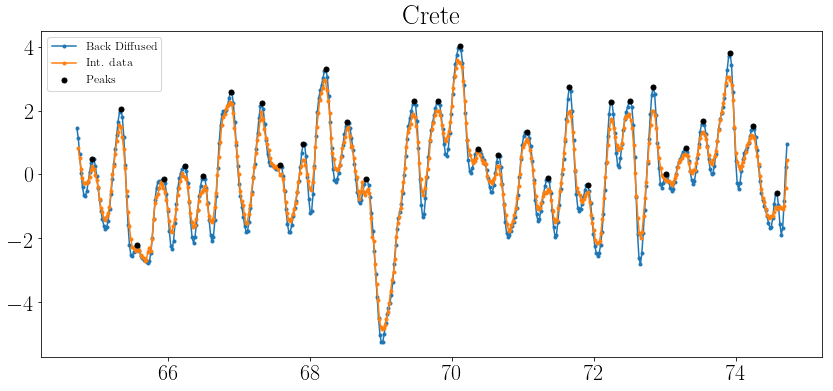

In [187]:
fig, ax = plt.subplots(figsize=(14,6))

plt.plot(depth1,data, '-', marker='.',label='Back Diffused')
plt.plot(depth_LT_int,d18O_LT_int-np.mean(d18O_LT_int),'-',marker='.', label='Int. data')
plt.plot(depth1[peaks],data[peaks],'.', color='k', ms=10, label='Peaks')
plt.title(site)
plt.legend(fontsize=12)

Define interval of sampling sizes to run through.

In [27]:
delta_arr = np.linspace(0.01, 0.1, 41)
delta_arr

array([0.01   , 0.01225, 0.0145 , 0.01675, 0.019  , 0.02125, 0.0235 ,
       0.02575, 0.028  , 0.03025, 0.0325 , 0.03475, 0.037  , 0.03925,
       0.0415 , 0.04375, 0.046  , 0.04825, 0.0505 , 0.05275, 0.055  ,
       0.05725, 0.0595 , 0.06175, 0.064  , 0.06625, 0.0685 , 0.07075,
       0.073  , 0.07525, 0.0775 , 0.07975, 0.082  , 0.08425, 0.0865 ,
       0.08875, 0.091  , 0.09325, 0.0955 , 0.09775, 0.1    ])

Run through all sampling sizes in interval and compute diffusion lengths.

In [28]:

interval = np.array([min(depth_LT), max(depth_LT)])
interpTypeAll = 'CubicSpline'

diffLens = np.zeros(len(delta_arr))
Npeaks = np.zeros(len(delta_arr))
depths_BD = []
datas_BD = []
depth_ints = []
data_ints = []
for i in range(len(delta_arr)):  
    print(f'\nRun {i}')
    print(f'Delta: {delta_arr[i]:.3f}\n')
    inst = Interpolation(depth_LT, pd.Series(d18O_LT), interval, interpTypeAll, DeltaInput=True, samplingSize=delta_arr[i])
    depth_LT_int1, d18O_LT_int1, Delta = inst()
    
    depth_ints.append(depth_LT_int1)
    data_ints.append(d18O_LT_int1)
    
    dataAll = pd.DataFrame({'depth':depth_LT_int1,'d18O':d18O_LT_int1}, index=None)

    inst = BackDiffuse(site, dataAll, CoresSpecs, dTamb, dLaki, 32, diffLenData=data_diff_LT[['Depth','sigma_o18']], densData=data_dens_LT)
    diffLen = inst.spectralEstimate()
    difflenEstHL = inst.diffLenEstimateHL()
    depth1, data, diffLen, peaks, arr_DiffLens, arr_Npeaks, arr_depth, arr_data = inst.backDiffused(theoDiffLen=True,print_Npeaks=False, diffLenStart_In=0.005, diffLenEnd_In=0.15, interpAfterDecon=False, newDelta=0.005)
    
    Npeaks[i] = len(peaks)
    diffLens[i] = diffLen
    depths_BD.append(depth1)
    datas_BD.append(data)


Run 0
Delta: 0.010

Starting sigma: 2.67 [cm]
Final sigma: 2.10 [cm]
Final # of peaks: 32
Delta: 0.010
Delta new: 0.010

Run 1
Delta: 0.012

Starting sigma: 4.19 [cm]
100. Npeaks: 33, diffLen: 3.189 cm
Final sigma: 3.08 [cm]
Final # of peaks: 32
Delta: 0.012
Delta new: 0.012

Run 2
Delta: 0.015

Starting sigma: 4.22 [cm]
Final sigma: 3.47 [cm]
Final # of peaks: 32
Delta: 0.014
Delta new: 0.014

Run 3
Delta: 0.017

Starting sigma: 5.88 [cm]
Final sigma: 5.73 [cm]
Final # of peaks: 32
Delta: 0.017
Delta new: 0.017

Run 4
Delta: 0.019

Starting sigma: 6.10 [cm]
Final sigma: 6.06 [cm]
Final # of peaks: 32
Delta: 0.019
Delta new: 0.019

Run 5
Delta: 0.021

Starting sigma: 5.89 [cm]
Final sigma: 5.94 [cm]
Final # of peaks: 32
Delta: 0.021
Delta new: 0.021

Run 6
Delta: 0.024

Starting sigma: 6.62 [cm]
Final sigma: 6.42 [cm]
Final # of peaks: 32
Delta: 0.023
Delta new: 0.023

Run 7
Delta: 0.026

Starting sigma: 6.07 [cm]
Final sigma: 6.32 [cm]
Final # of peaks: 32
Delta: 0.026
Delta new: 0.0

/home/thea/Documents/KUFysik/MesterTesen/Analysis/Decon.py:211: RuntimeWarning: divide by zero encountered in log10
  res = weights*(np.log10(y) - np.log10(np.copy(Pmod)))
/home/thea/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/thea/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):
/home/thea/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):
/home/thea/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1
/home/thea/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in less
  violated = (x < lb) | (x > ub)
/home

100. Npeaks: 15, diffLen: 1.005 cm
200. Npeaks: 15, diffLen: 2.010 cm
300. Npeaks: 17, diffLen: 3.015 cm
400. Npeaks: 18, diffLen: 4.020 cm
500. Npeaks: 19, diffLen: 5.025 cm
600. Npeaks: 25, diffLen: 6.030 cm
700. Npeaks: 30, diffLen: 7.035 cm
800. Npeaks: 30, diffLen: 8.040 cm
900. Npeaks: 31, diffLen: 9.045 cm
1000. Npeaks: 32, diffLen: 10.046 cm
Final sigma: 10.09 [cm]
Final # of peaks: 32
Delta: 0.099
Delta new: 0.099

Run 40
Delta: 0.100

Starting sigma: 6.66 [cm]
100. Npeaks: 27, diffLen: 7.669 cm
200. Npeaks: 30, diffLen: 8.674 cm
300. Npeaks: 31, diffLen: 9.679 cm
400. Npeaks: 32, diffLen: 10.682 cm
Final sigma: 11.35 [cm]
Final # of peaks: 32
Delta: 0.101
Delta new: 0.101


In [13]:
#fig, ax = plt.subplots(figsize=(14,6))
#ax.set(ylim=(-10,10))
#for i in range(len(delta_arr)-2):  
#    ax.plot(depths[i],datas[i], lw=1, marker='.')

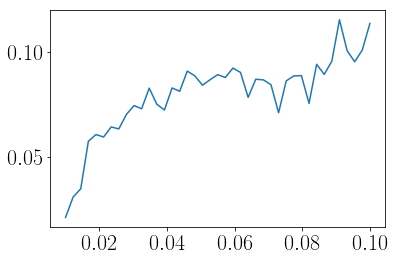

In [29]:
plt.plot(delta_arr, diffLens)


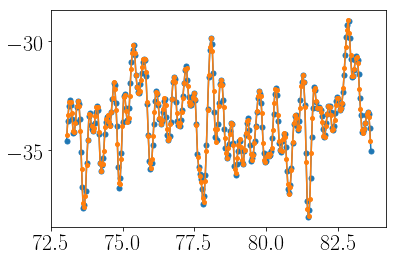

In [17]:
i=13
plt.plot(depth_LT_int, d18O_LT_int,'-',marker='.', ms=10)
plt.plot(depth_ints[i], data_ints[i],'-',marker='.', ms=8)

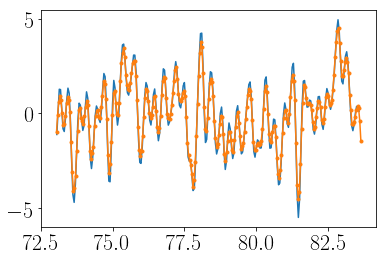

In [18]:
plt.plot(depths_BD[i],datas_BD[i])
plt.plot(depth_LT_int, d18O_LT_int-np.mean(d18O_LT_int),'-',marker='.')

array([0.0230625 , 0.02477083, 0.02647917, 0.0281875 , 0.02989583,
       0.03160417, 0.0333125 , 0.03502083, 0.03672917, 0.0384375 ])